# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter.

In [1]:
# you will be prompted with a window asking to grant permissions
COLAB = True
if COLAB:
    from google.colab import drive
    drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
if COLAB:
    work_dir = "/content/drive/MyDrive/CS444/assignment4/"
else:
    work_dir = "/home/changl25/private/assignment4/"
if not os.path.exists(work_dir) and COLAB:
  !ln -s "/content/drive/MyDrive/CS444/assignment4/" $work_dir # TODO: Fill your Assignment 3 path
os.chdir(work_dir)
!pwd

/content/drive/MyDrive/CS444/assignment4


In [ ]:
! wget https://uofi.box.com/shared/static/pq6nt3o77vujmxhpkb0ixssa8xjvnrpu.zip
! unzip pq6nt3o77vujmxhpkb0ixssa8xjvnrpu.zip
! rm pq6nt3o77vujmxhpkb0ixssa8xjvnrpu.zip

--2024-04-13 19:27:00--  https://uofi.box.com/shared/static/pq6nt3o77vujmxhpkb0ixssa8xjvnrpu.zip
Resolving uofi.box.com (uofi.box.com)... 74.112.186.144
Connecting to uofi.box.com (uofi.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/pq6nt3o77vujmxhpkb0ixssa8xjvnrpu.zip [following]
--2024-04-13 19:27:00--  https://uofi.box.com/public/static/pq6nt3o77vujmxhpkb0ixssa8xjvnrpu.zip
Reusing existing connection to uofi.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://uofi.app.box.com/public/static/pq6nt3o77vujmxhpkb0ixssa8xjvnrpu.zip [following]
--2024-04-13 19:27:00--  https://uofi.app.box.com/public/static/pq6nt3o77vujmxhpkb0ixssa8xjvnrpu.zip
Resolving uofi.app.box.com (uofi.app.box.com)... 74.112.186.144
Connecting to uofi.app.box.com (uofi.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcl

# Generative Adversarial Networks

For this part of the assignment you implement two different types of generative adversarial networks. We will train the networks on a dataset of cat face images.

In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [4]:
from gan.train import train

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "gpu")
save_path = os.path.join(work_dir, "model")
os.makedirs(save_path, exist_ok=True)

# GAN loss functions

In this assignment you will implement two different types of GAN cost functions. You will first implement the loss from the [original GAN paper](https://arxiv.org/pdf/1406.2661.pdf). You will also implement the loss from [LS-GAN](https://arxiv.org/abs/1611.04076).

### GAN loss

**TODO:** Implement the `discriminator_loss` and `generator_loss` functions in `gan/losses.py`.

The generator loss is given by:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: You should use the `torch.nn.functional.binary_cross_entropy_with_logits` function to compute the binary cross entropy loss since it is more numerically stable than using a softmax followed by BCE loss. The BCE loss is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$


Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [6]:
from gan.losses import discriminator_loss, generator_loss

### Least Squares GAN loss

**TODO:** Implement the `ls_discriminator_loss` and `ls_generator_loss` functions in `gan/losses.py`.

We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

In [7]:
from gan.losses import ls_discriminator_loss, ls_generator_loss

# GAN model architecture

**TODO:** Implement the `Discriminator` and `Generator` networks in `gan/models.py`.

We recommend the following architectures which are inspired by [DCGAN](https://arxiv.org/pdf/1511.06434.pdf):

**Discriminator:**

- convolutional layer with in_channels=3, out_channels=128, kernel=4, stride=2
- convolutional layer with in_channels=128, out_channels=256, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=256, out_channels=512, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=512, out_channels=1024, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=1024, out_channels=1, kernel=4, stride=1

Use padding = 1 (not 0) for all the convolutional layers.

Instead of Relu we LeakyReLu throughout the discriminator (we use a negative slope value of 0.2). You can use simply use relu as well.

The output of your discriminator should be a single value score corresponding to each input sample. See `torch.nn.LeakyReLU`.


**Generator:**

**Note:** In the generator, you will need to use transposed convolution (sometimes known as fractionally-strided convolution or deconvolution). This function is implemented in pytorch as `torch.nn.ConvTranspose2d`.

- transpose convolution with in_channels=NOISE_DIM, out_channels=1024, kernel=4, stride=1
- batch norm
- transpose convolution with in_channels=1024, out_channels=512, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=512, out_channels=256, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=256, out_channels=128, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=128, out_channels=3, kernel=4, stride=2

The output of the final layer of the generator network should have a `tanh` nonlinearity to output values between -1 and 1. The output should be a 3x64x64 tensor for each sample (equal dimensions to the images from the dataset).





In [8]:
from gan.models import Discriminator, Generator

# Data loading

The cat images we provide are RGB images with a resolution of 64x64. In order to prevent our discriminator from overfitting, we will need to perform some data augmentation.

**TODO:** Implement data augmentation by adding new transforms to the cell below. At the minimum, you should have a RandomCrop and a ColorJitter, but we encourage you to experiment with different augmentations to see how the performance of the GAN changes. See https://pytorch.org/vision/stable/transforms.html.


In [ ]:
batch_size = 64
imsize = 64
cat_root = './cats'

cat_train = ImageFolder(root=cat_root, transform=transforms.Compose([
  transforms.ToTensor(),
  transforms.RandomResizedCrop(imsize, antialias=True),
  transforms.RandomHorizontalFlip(p=0.5),
  # transforms.RandomRotation(30),
  transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
]))

cat_loader_train = DataLoader(cat_train, batch_size=batch_size, drop_last=True)

### Visualize dataset

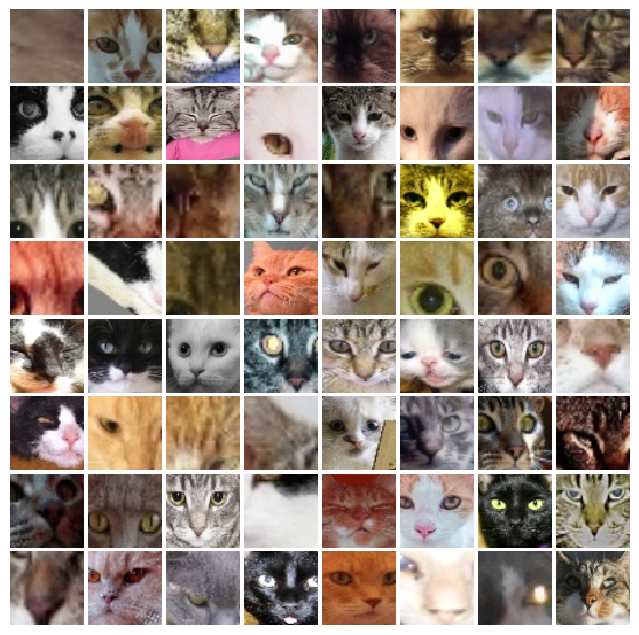

In [ ]:
from gan.utils import show_images

try:
  imgs = next(iter(cat_loader_train))[0].numpy().squeeze()
except:
  imgs = cat_loader_train.__iter__().next()[0].numpy().squeeze()

show_images(imgs, color=True)

# Training


**TODO:** Fill in the training loop in `gan/train.py`.

In [25]:
NOISE_DIM = 100
NUM_EPOCHS = 20
learning_rate = 0.001

### Train GAN

In [48]:
D = Discriminator().to(device)
G = Generator(noise_dim=NOISE_DIM).to(device)

In [ ]:
pretrained = True
if pretrained:
  D.load_state_dict(torch.load(os.path.join(save_path, "discriminator_0.0002_50.pth.tar"), map_location=device))
  G.load_state_dict(torch.load(os.path.join(save_path, "generate_0.0002_50.pth.tar"), map_location=device))

In [ ]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

In [ ]:
# original gan
train(D, G, D_optimizer, G_optimizer, discriminator_loss,
          generator_loss, num_epochs=NUM_EPOCHS, show_every=50,
          batch_size=batch_size, train_loader=cat_loader_train, device=device)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
g_state_dict = G.state_dict()
d_state_dict = D.state_dict()
torch.save(g_state_dict, os.path.join(save_path, f"generate_{learning_rate}_{NUM_EPOCHS}.pth.tar"))
torch.save(d_state_dict, os.path.join(save_path, f"discriminator_{learning_rate}_{NUM_EPOCHS}.pth.tar"))

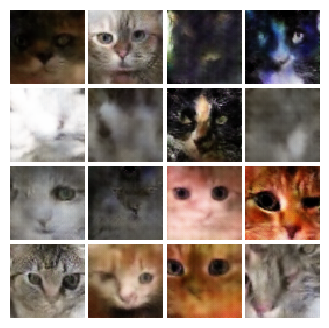

In [ ]:
from gan.utils import sample_noise, deprocess_img
noise = sample_noise(batch_size, NOISE_DIM).to(device)
noise = noise.view(batch_size, NOISE_DIM, 1, 1)
fake_images = G(noise)
fake_images = fake_images.view(batch_size, 3, imsize, imsize)
disp_fake_images = deprocess_img(fake_images.data)  # denormalize
imgs_numpy = (disp_fake_images).cpu().numpy()
show_images(imgs_numpy[0:16], color=3 != 1)
plt.show()
print()

### Train LS-GAN

In [ ]:
D = Discriminator().to(device)
G = Generator(noise_dim=NOISE_DIM).to(device)

In [ ]:
learning_rate = 0.0007

In [ ]:
pretrained = True
if pretrained:
  D.load_state_dict(torch.load(os.path.join(save_path, "lsdiscriminator_0.0007_70.pth.tar"), map_location=device))
  G.load_state_dict(torch.load(os.path.join(save_path, "lsgenerate_0.0007_70.pth.tar"), map_location=device))

In [ ]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

EPOCH:  1
Iter: 0, D: 0.09117, G:0.322


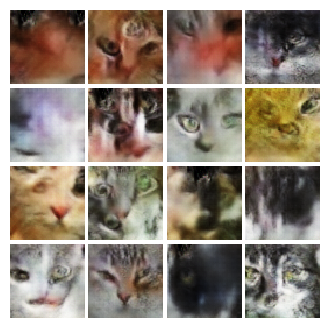


Iter: 150, D: 0.07638, G:0.3918


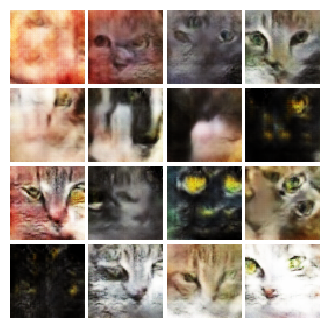

KeyboardInterrupt: 

In [ ]:
# ls-gan
train(D, G, D_optimizer, G_optimizer, ls_discriminator_loss,
          ls_generator_loss, num_epochs=30, show_every=150,
          batch_size=batch_size, train_loader=cat_loader_train, device=device)

In [ ]:
g_state_dict = G.state_dict()
d_state_dict = D.state_dict()
torch.save(g_state_dict, os.path.join(save_path, f"lsgenerate_{learning_rate}_{70}.pth.tar"))
torch.save(d_state_dict, os.path.join(save_path, f"lsdiscriminator_{learning_rate}_{70}.pth.tar"))

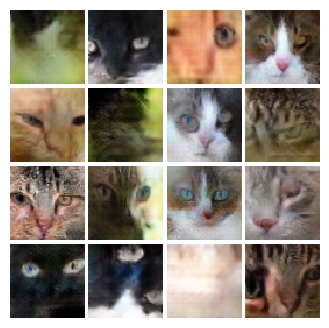

In [ ]:
noise = sample_noise(batch_size, NOISE_DIM).to(device)
noise = noise.view(batch_size, NOISE_DIM, 1, 1)
fake_images = G(noise)
fake_images = fake_images.view(batch_size, 3, imsize, imsize)
disp_fake_images = deprocess_img(fake_images.data)  # denormalize
imgs_numpy = (disp_fake_images).cpu().numpy()
show_images(imgs_numpy[0:16], color=3 != 1)
plt.show()
print()

## Extra credits

In [ ]:
! pip install lmdb
! python3 download.py -c bedroom

In [ ]:
import torchvision
lsun_dataset = cat_train = torchvision.datasets.LSUN(root="lsun", classes="bedroom", transform=transforms.Compose([
  transforms.ToTensor(),
  transforms.RandomResizedCrop(imsize, antialias=True),
  transforms.RandomHorizontalFlip(p=0.5),
  # transforms.RandomRotation(30),
  transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
]))

lsun_loader_train = DataLoader(lsun_dataset, batch_size=batch_size, drop_last=True)


In [ ]:
try:
  imgs = next(iter(lsun_loader_train))[0].numpy().squeeze()
except:
  imgs = lsun_loader_train.__iter__().next()[0].numpy().squeeze()

show_images(imgs, color=True)

In [ ]:
D = Discriminator().to(device)
G = Generator(noise_dim=NOISE_DIM).to(device)

In [ ]:
learning_rate = 0.0007

In [ ]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

In [ ]:
train(D, G, D_optimizer, G_optimizer, discriminator_loss,
          generator_loss, num_epochs=NUM_EPOCHS, show_every=50,
          batch_size=batch_size, train_loader=lsun_loader_train, device=device)